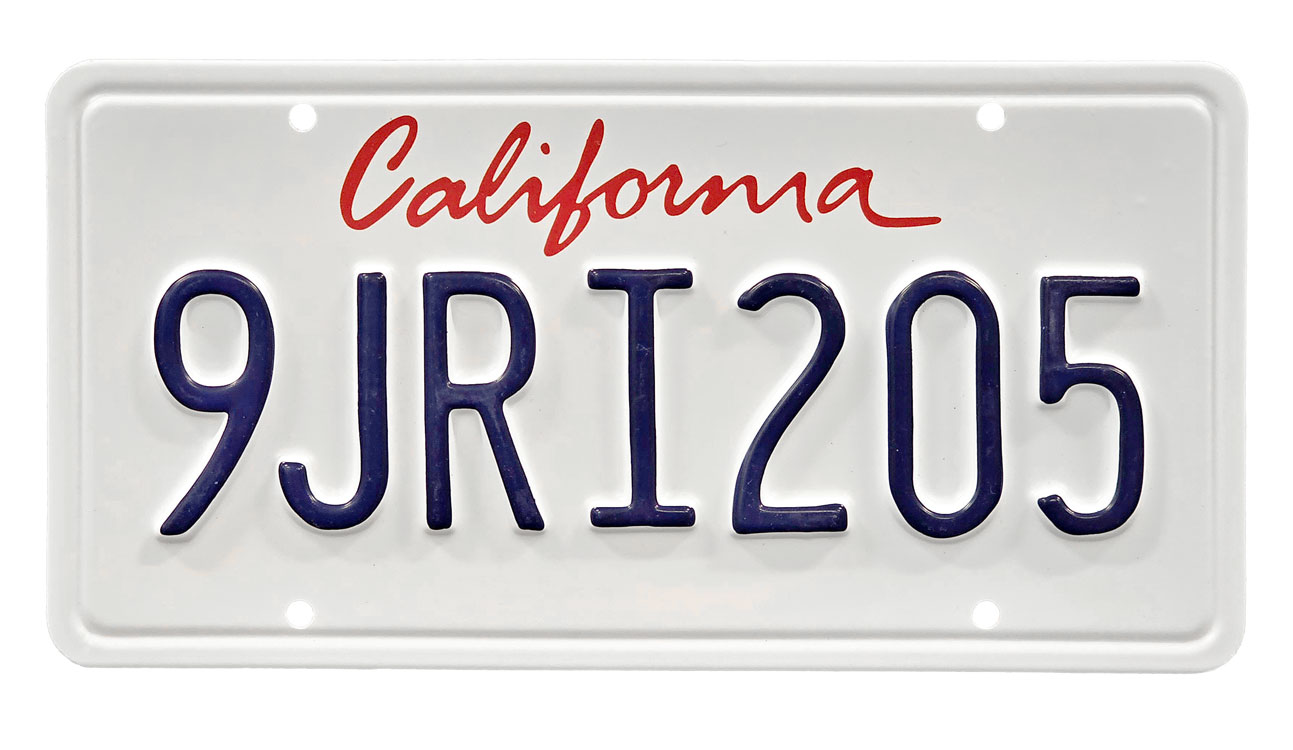

**Problem Definition**
Develop a computer-vision model that processes vehicle images and outputs the **bounding-box coordinates** of each license plate. Using a dataset of annotated car photographs—where each image is tagged with plate location—you will train a system to:

1. **Detect Plates:** Identify and localize every visible license plate by producing tight, accurate bounding boxes, even under challenging conditions such as varied lighting, angles, occlusions, and motion blur.
2. **Optimize Localization Metrics:** Maximize intersection-over-union (IoU) and mean average precision (mAP) for plate bounding boxes on a held-out test set.

Accurate plate localization is critical for downstream applications like automated toll collection, parking access control, law-enforcement imaging systems, and real-time traffic monitoring.


# Install Main tools

In [1]:
!pip install ultralytics -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import pandas as pd
import shutil
from ultralytics import YOLO
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### Convert the current dataset to a yolo format. like the format in the official github website.
#### We have the _annotations.csv file in each split folder, so we are going to use them in the conversion process.

In [3]:
# convert function
def convert_and_organize(split_name):
    csv_path = f"/kaggle/input/license-plate-recognition/{split_name}/{split_name}/_annotations.csv"
    img_src = f"/kaggle/input/license-plate-recognition/{split_name}/{split_name}"
    img_dst = f"/kaggle/working/dataset/images/{split_name}"
    label_dst = f"/kaggle/working/dataset/labels/{split_name}"

    os.makedirs(img_dst, exist_ok=True)
    os.makedirs(label_dst, exist_ok=True)

    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        filename = row['filename']
        width = row['width']
        height = row['height']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']

        # Convert to YOLO format
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height

        yolo_line = f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n"

        # Save label file
        txt_file = os.path.splitext(filename)[0] + ".txt"
        with open(os.path.join(label_dst, txt_file), 'a') as f:
            f.write(yolo_line)

        # Copy image
        src_img_path = os.path.join(img_src, filename)
        dst_img_path = os.path.join(img_dst, filename)
        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, dst_img_path)

# Run for all splits
for split in ['train', 'valid', 'test']:
    convert_and_organize(split)


#### Create the YAML file. so yolo knows on what to train.

In [4]:
yaml_content = """
path: /kaggle/working/dataset
train: images/train
val: images/valid
test: images/test

names:
  0: license_plate
"""


with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(yaml_content)


## Choose the model

In [5]:
# Or any yolo version like v5
model = YOLO("yolov8n.pt") 

100%|██████████| 6.25M/6.25M [00:00<00:00, 362MB/s]


## Train the model

In [6]:
model.train(
    data="/kaggle/working/dataset.yaml",
    epochs=30,
    imgsz=640,
    batch=32
)


Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

100%|██████████| 755k/755k [00:00<00:00, 121MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 363MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 807.9±657.3 MB/s, size: 37.5 KB)


train: Scanning /kaggle/working/dataset/labels/train... 7052 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7052/7052 [00:04<00:00, 1541.26it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 378.6±173.6 MB/s, size: 18.9 KB)


val: Scanning /kaggle/working/dataset/labels/valid... 2045 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2045/2045 [00:02<00:00, 865.70it/s] 

val: New cache created: /kaggle/working/dataset/labels/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.82G      1.239      1.565      1.142         21        640: 100%|██████████| 221/221 [01:13<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


                   all       2045       2195      0.862      0.845      0.869      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.35G      1.253     0.8706       1.15         32        640: 100%|██████████| 221/221 [01:11<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]

                   all       2045       2195      0.881      0.766      0.847      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.36G      1.244     0.7593      1.149         25        640: 100%|██████████| 221/221 [01:09<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]

                   all       2045       2195      0.949      0.844      0.913      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.39G      1.236     0.7243      1.139         25        640: 100%|██████████| 221/221 [01:09<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]

                   all       2045       2195      0.932      0.861      0.914      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.39G      1.203     0.6782      1.122         29        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

                   all       2045       2195      0.958        0.9      0.943      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.42G      1.189     0.6534      1.114         23        640: 100%|██████████| 221/221 [01:09<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]

                   all       2045       2195      0.955      0.891      0.939      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.43G      1.175     0.6239      1.102         30        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]

                   all       2045       2195      0.956      0.902      0.942      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.46G      1.158      0.609      1.099         21        640: 100%|██████████| 221/221 [01:09<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

                   all       2045       2195      0.964      0.919      0.954      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.46G      1.144     0.5864      1.089         26        640: 100%|██████████| 221/221 [01:09<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all       2045       2195      0.976      0.925      0.958      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.49G      1.139     0.5773      1.086         31        640: 100%|██████████| 221/221 [01:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]

                   all       2045       2195      0.978      0.912      0.951      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       6.5G      1.117     0.5588      1.078         21        640: 100%|██████████| 221/221 [01:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

                   all       2045       2195      0.967      0.925      0.962      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.52G       1.13      0.559      1.079         22        640: 100%|██████████| 221/221 [01:09<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       2045       2195      0.981      0.929      0.964       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.53G      1.112     0.5426      1.071         25        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

                   all       2045       2195      0.977      0.921      0.959      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.56G        1.1     0.5278      1.063         27        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       2045       2195      0.982      0.925      0.963      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.56G      1.097      0.523       1.06         15        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       2045       2195      0.971      0.938      0.967      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.59G      1.085     0.5121      1.052         23        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       2045       2195      0.978      0.934      0.968      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       6.6G      1.083     0.5068      1.055         22        640: 100%|██████████| 221/221 [01:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all       2045       2195      0.983      0.925      0.962      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.62G      1.079     0.5005      1.051         23        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]

                   all       2045       2195      0.977      0.936      0.964      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.63G      1.058     0.4852      1.042         26        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       2045       2195      0.985      0.935      0.967       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.66G      1.065     0.4821      1.041         24        640: 100%|██████████| 221/221 [01:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]

                   all       2045       2195      0.986      0.937      0.971      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.67G      1.056     0.4433      1.056         12        640: 100%|██████████| 221/221 [01:10<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

                   all       2045       2195      0.984       0.93      0.968      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       6.7G      1.052     0.4445       1.06         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

                   all       2045       2195      0.976      0.935      0.967      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       6.7G      1.039     0.4328      1.046         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]

                   all       2045       2195      0.987      0.937      0.968      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.73G       1.03     0.4217      1.046         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

                   all       2045       2195      0.987      0.937      0.969        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.74G      1.018      0.411      1.044         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]

                   all       2045       2195       0.98      0.939      0.969      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.76G      1.011     0.4074      1.036         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

                   all       2045       2195      0.988      0.938      0.971      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.77G      1.002     0.3962      1.032         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]

                   all       2045       2195      0.986       0.94       0.97      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       6.8G     0.9902     0.3887      1.028         13        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

                   all       2045       2195      0.988      0.937      0.969      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       6.8G     0.9809     0.3802      1.022         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       2045       2195      0.987       0.94      0.972      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.83G     0.9714     0.3725      1.019         12        640: 100%|██████████| 221/221 [01:08<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]

                   all       2045       2195      0.986       0.94      0.972       0.71



30 epochs completed in 0.662 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2045       2195      0.986       0.94      0.972       0.71
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca21f301250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

📊 YOLOv8 results_dict:

🔹 Precision:      98.04%  – The model made very few false detections.
🔹 Recall:         94.31%  – Most license plates in the images were detected.
🔸 Fitness Score:  74.05%  – Overall model quality combining all core metrics.


## Evaluate the model

In [7]:
# Validation metrics
metrics = model.val()

# Prediction on test images
results = model.predict("/kaggle/working/dataset/images/test", save=True, stream=False, verbose=False)


Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 601.6±184.8 MB/s, size: 17.1 KB)


val: Scanning /kaggle/working/dataset/labels/valid.cache... 2045 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2045/2045 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2045       2195      0.987       0.94      0.972       0.71
Speed: 0.3ms preprocess, 1.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to runs/detect/train3


#### Predict a bounding box for a sample and draw it

In [8]:
image_url = "https://www.opportunityvillage.org/wp-content/uploads/2022/07/personalized-license-plates.jpeg"

In [9]:
def load_image_from_url(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        return image
    else:
        raise Exception("Failed to load image from URL")



image = load_image_from_url(image_url)


In [10]:
results = model.predict(source=image, conf=0.25)

# Get image with bounding boxes drawn
annotated_frame = results[0].plot()



0: 448x640 1 license_plate, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


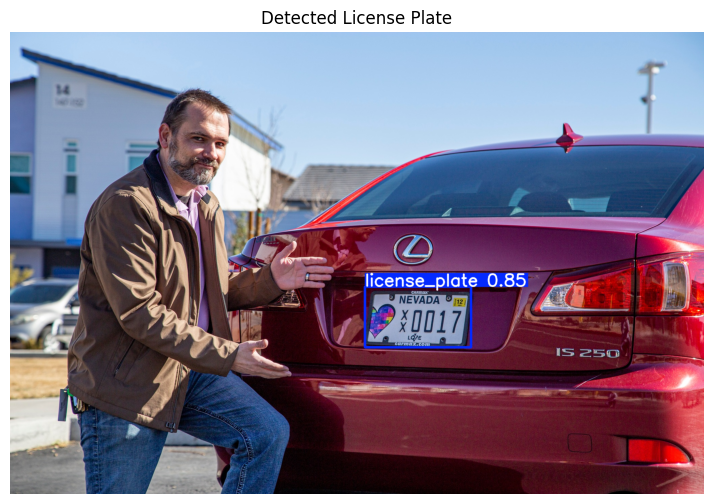

In [11]:
image_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Detected License Plate")
plt.show()


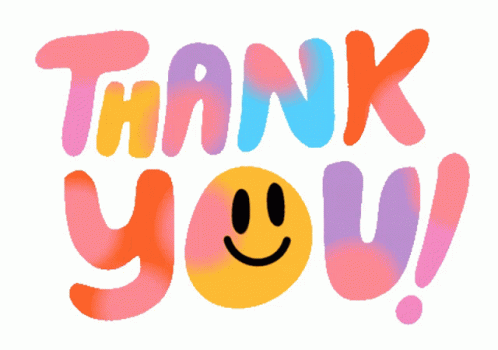